In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchvision
!pip install torchmetrics
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import torchvision
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
import shutil
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.optim as optim
from torch.optim import lr_scheduler

Preprocess the data

In [158]:
# Path to dataset
train_dataset_path = '/content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/'
test_image_path = sorted(glob.glob(os.path.join(train_dataset_path, 'Images/*.jpg')))

test_mask_path = sorted(glob.glob(os.path.join(train_dataset_path, 'Ground_Truth/*.png')))


# Function to extract the number from the file name
def extract_number(file_path):
    base_name = os.path.basename(file_path)
    number = base_name.split('_')[1].split('.')[0]
    return number

# Filter function to retain matching files
def filter_matching_files(list1, list2):
    filtered_list1 = []
    filtered_list2 = []

    numbers_list2 = [extract_number(path) for path in list2]

    for path1 in list1:
        number1 = extract_number(path1)
        if number1 in numbers_list2:
            filtered_list1.append(path1)
            filtered_list2.append(list2[numbers_list2.index(number1)])

    return filtered_list1, filtered_list2

# Apply the filter function
train_filtered_list, mask_filtered_list = filter_matching_files(test_image_path, test_mask_path)
train_filtered_list = train_filtered_list[:500]
mask_filtered_list = mask_filtered_list[:500]

# Print the results
print("Filtered List 1:", train_filtered_list[-1])
print("Filtered List 2:", mask_filtered_list[-1])

print(len(train_filtered_list))
print(len(mask_filtered_list))



Filtered List 1: /content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/Images/ISIC_0001306.jpg
Filtered List 2: /content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/Ground_Truth/ISIC_0001306_segmentation.png
500
500


The image path is: /content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/Images/ISIC_0000000.jpg
The mask path is: /content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/Ground_Truth/ISIC_0000000_segmentation.png


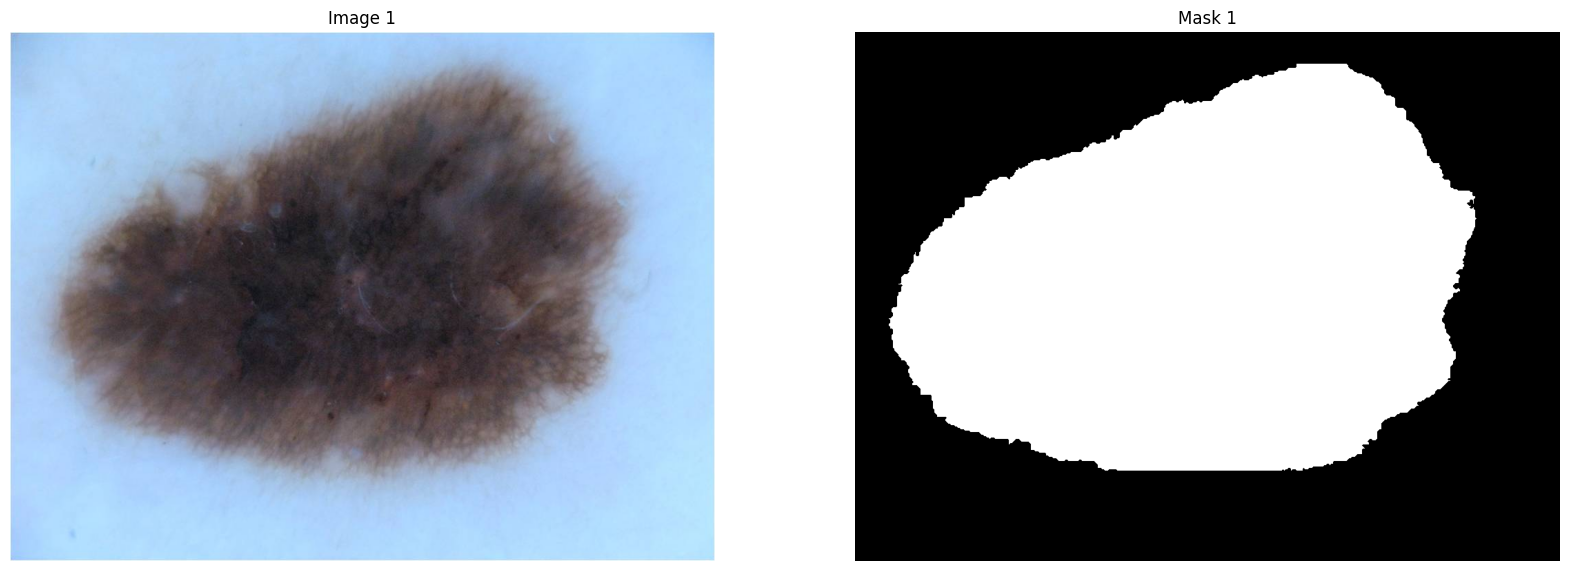

The image path is: /content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/Images/ISIC_0000001.jpg
The mask path is: /content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/Ground_Truth/ISIC_0000001_segmentation.png


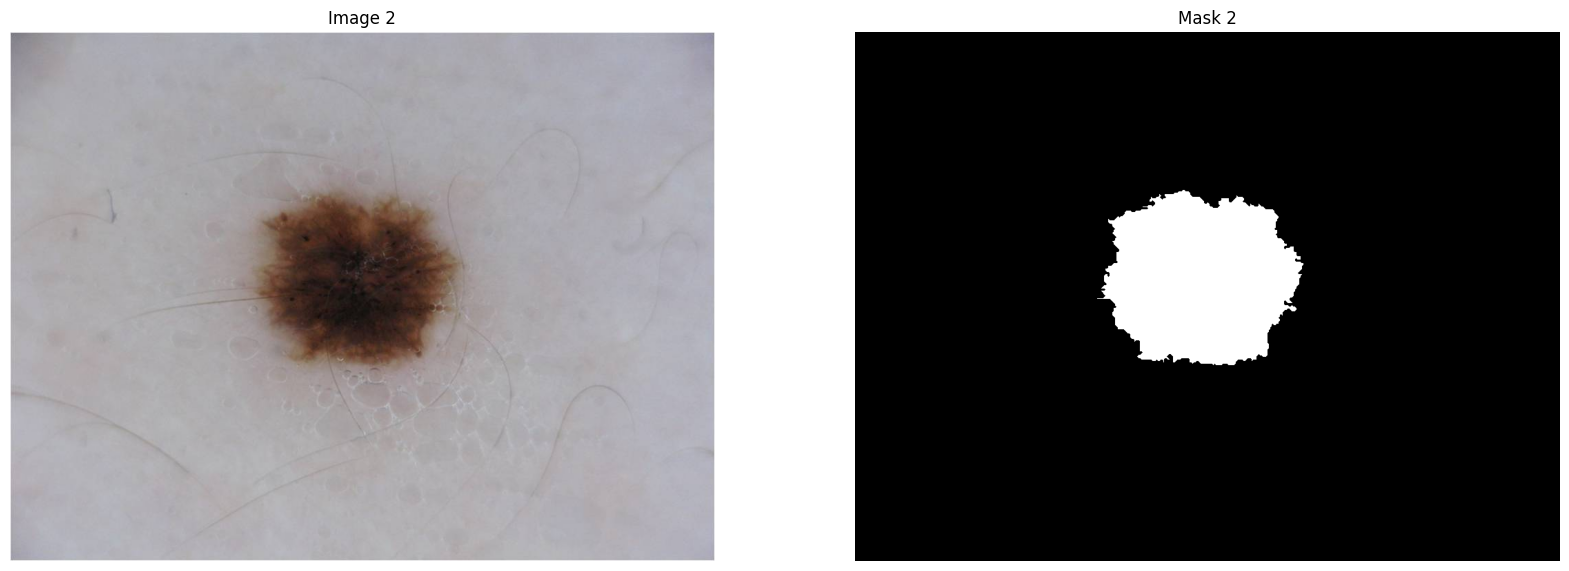

The image path is: /content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/Images/ISIC_0000003.jpg
The mask path is: /content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/Ground_Truth/ISIC_0000003_segmentation.png


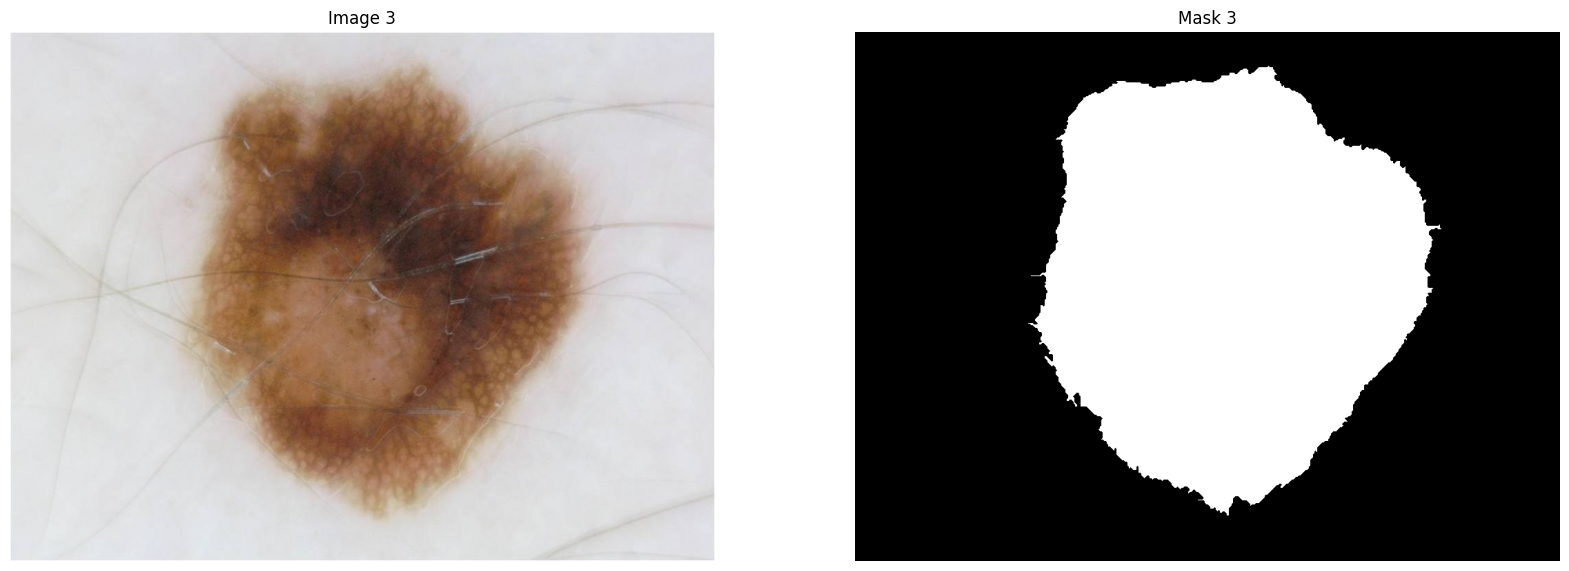

The image path is: /content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/Images/ISIC_0000004.jpg
The mask path is: /content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/Ground_Truth/ISIC_0000004_segmentation.png


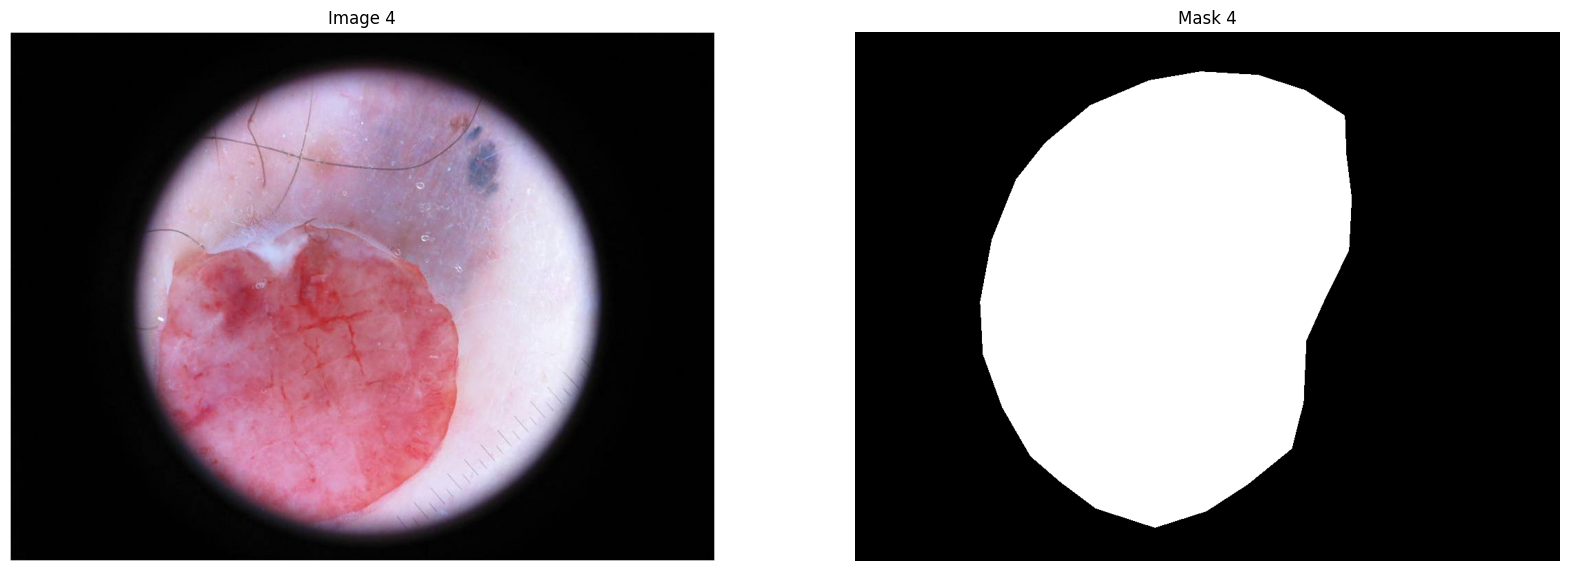

The image path is: /content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/Images/ISIC_0000006.jpg
The mask path is: /content/drive/MyDrive/Skin_Lesion_Segmentation/Dataset/Ground_Truth/ISIC_0000006_segmentation.png


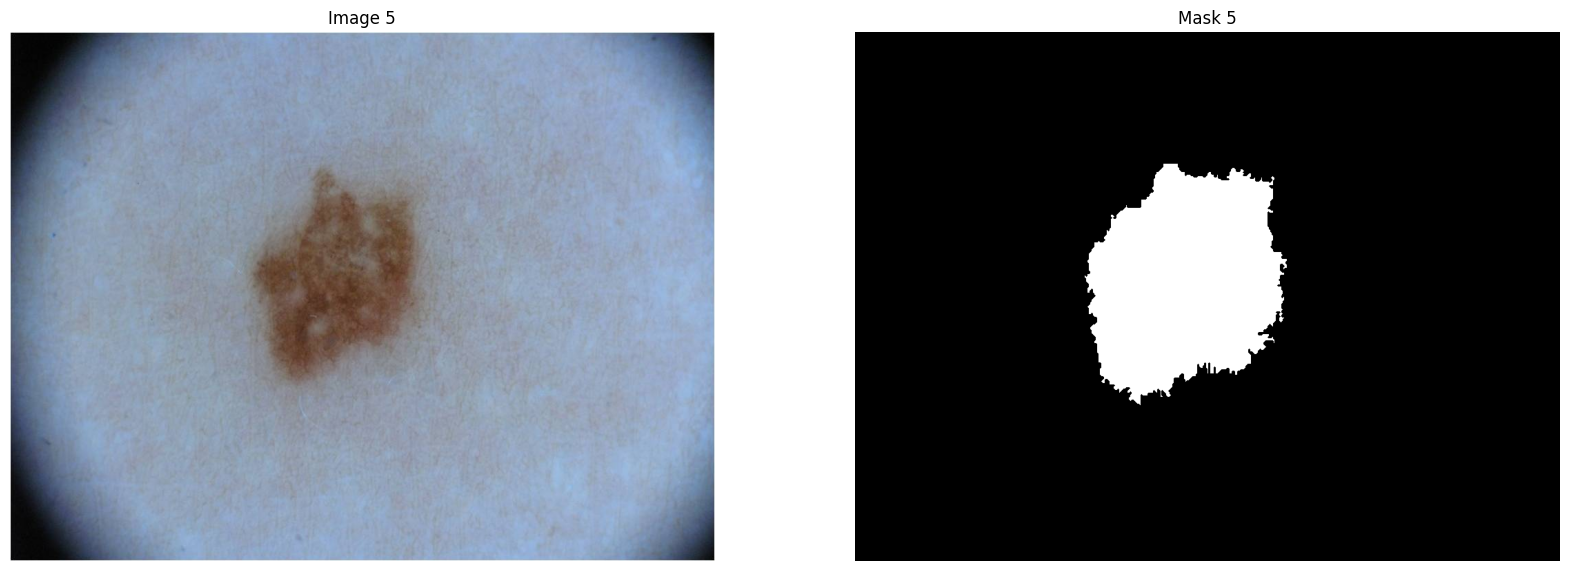

In [159]:
for i in range(5):
    print(f'The image path is: {test_image_path[i]}')
    print(f'The mask path is: {test_mask_path[i]}')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    # Load the image and mask using OpenCV
    test_image = cv2.imread(test_image_path[i])

    mask_image = cv2.imread(test_mask_path[i])


    # Convert the image from BGR to RGB
    test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    # Display the image
    ax1.imshow(test_image_rgb)
    ax1.set_title(f'Image {i+1}')
    ax1.axis('off')  # Hide axis

    # Display the mask
    ax2.imshow(mask_image, cmap='gray')
    ax2.set_title(f'Mask {i+1}')
    ax2.axis('off')  # Hide axis

    # Show the plot
    plt.show()

In [160]:
class MyDataset(Dataset):
  def __init__(self, files_path, transform):
    self.files_path = files_path
    self.transform = transform

  def get_files_path(self):
    return self.files_path

  def __len__(self):
    return len(self.get_files_path())

  def __getitem__(self, idx):
    image_path = self.get_files_path()[idx]['image']
    mask_path = self.get_files_path()[idx]['label']

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255.0
    image = np.expand_dims(image, axis = 2)
    image = torch.tensor(image, dtype = torch.float32)
    image = image.permute(2, 0, 1)


    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0
    mask = np.expand_dims(mask, axis = 0)
    mask = torch.tensor(mask, dtype = torch.float32)


    sample = {'image': image, 'label': mask}
    if self.transform:
      sample = self.transform(sample)
    return sample


def split_dataset(image_dir_list, mask_dir_list, train_size, val_size, test_size, random_state = 42):

  # Ensure the number of image and mask is the same
  assert(len(image_dir_list) == len(mask_dir_list))

  dataset = list(zip(image_dir_list, mask_dir_list))

  train_val_data, test_path = train_test_split(dataset, test_size = test_size, random_state = 42)
  train_path, val_path = train_test_split(train_val_data, test_size = val_size / (val_size + train_size), random_state = 42)

  return  train_path, val_path, test_path

In [178]:
import random
class ResizeImg:
  def __call__(self, sample):
    image, label = sample['image'], sample['label']

    resize_image = torchvision.transforms.Resize((128, 128))
    resize_mask = torchvision.transforms.Resize((128, 128))

    image = resize_image(image)
    label = resize_mask(label)

    return {'image': image, 'label': label}




class RandomFlip:
  def __call__(self, sample,  mode='horizontal'):
    """
    Flip an image and its corresponding label either horizontally, vertically, or both based on the given mode.

    Parameters:
    - image: torch tensor of shape (C, H, W) representing the input image.
    - label: torch tensor of shape (C, H, W) representing the segmentation label.
    - mode: string specifying the flip mode. It can be 'horizontal', 'vertical', 'both', or 'none'.

    Returns:
    - flipped_image: torch tensor of the flipped image.
    - flipped_label: torch tensor of the flipped label.

    """
    image, label = sample['image'], sample['label']
    if mode == 'horizontal':
        flipped_image = torch.flip(image, [2])  # Flip along width dimension
        flipped_label = torch.flip(label, [2])  # Flip along width dimension
    elif mode == 'vertical':
        flipped_image = torch.flip(image, [1])  # Flip along height dimension
        flipped_label = torch.flip(label, [1])  # Flip along height dimension
    elif mode == 'both':
        flipped_image = torch.flip(image, [1, 2])  # Flip along both height and width dimensions
        flipped_label = torch.flip(label, [1, 2])  # Flip along both height and width dimensions
    else:
        flipped_image = image
        flipped_label = label

    return {'image': flipped_image, 'label': flipped_label}


class RandomIntensityScale:
  def __call__(self, sample):
    image, label = sample['image'], sample['label']
    factor = random.uniform(0.9, 1.1)
    image = image * factor
    return {'image': image, 'label': label}

transform_train  = transforms.Compose(
    [
        RandomFlip(),
        ResizeImg(),
        RandomIntensityScale()

    ]
)

val_transform  = transforms.Compose(
    [
        ResizeImg()
    ]
)


In [179]:
# Split the dataset
train_list, val_list, test_list = split_dataset(train_filtered_list, mask_filtered_list, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42)

train_files_dict = [{'image': image_path, 'label': label_path} for image_path, label_path in train_list]
val_files_dict = [{'image': image_path, 'label': label_path} for image_path, label_path in val_list]
test_file_dict = [{'image': image_path, 'label': label_path} for image_path, label_path in test_list]


train_dataset = MyDataset(train_files_dict, transform = transform_train)
val_dataset = MyDataset(val_files_dict, transform = val_transform)
test_dataset = MyDataset(test_file_dict, transform = val_transform)

train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True, num_workers = 8, prefetch_factor = 2)
val_loader = DataLoader(val_dataset, batch_size = 2, shuffle = False, num_workers = 8, prefetch_factor = 2)
test_loader = DataLoader(test_dataset, batch_size = 2, shuffle = False, num_workers = 8, prefetch_factor = 2)


torch.Size([1, 128, 128])
torch.Size([1, 128, 128])


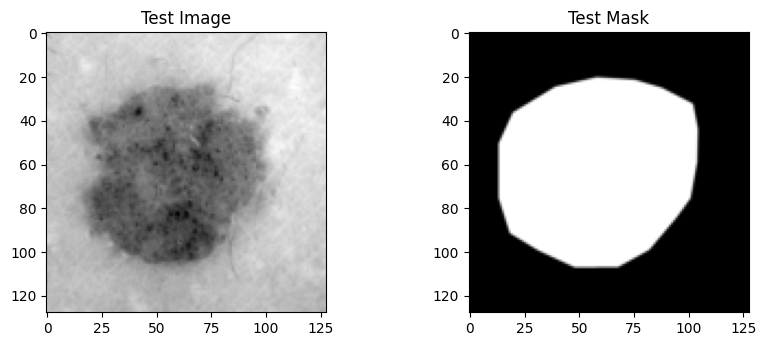

In [164]:
image = train_dataset[200]['image']
mask = train_dataset[200]['label']


print(image.shape)
print(mask.shape)
image = image.numpy().transpose((1,2,0))
mask = mask.numpy().transpose((1, 2, 0))

plt.figure(figsize=(10, 8))
plt.subplot(221)
plt.imshow(image, cmap = 'gray')
plt.title('Test Image')
plt.subplot(222)
plt.imshow(mask, cmap = 'gray')
plt.title('Test Mask')
plt.show()

UNet Architechture

In [165]:
class Encoder(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding= 1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace = True)


  def forward(self, x):
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))

    return x

class Decoder(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Decoder, self).__init__()
    self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2)
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
    self.bn1 = self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding= 1)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace = True)

  def forward(self, x, skip):
    x = self.upconv(x)
    x = torch.cat([x, skip], dim = 1)
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.relu(self.bn2(self.conv2(x)))
    return x


class UNET(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(UNET, self).__init__()
    self.enc1 = Encoder(in_channels, 64)
    self.enc2 = Encoder(64, 128)
    self.enc3 = Encoder(128, 256)
    self.enc4 = Encoder(256, 512)

    self.bottleneck = Encoder(512, 1024)

    self.dec4 = Decoder(1024, 512)
    self.dec3 = Decoder(512, 256)
    self.dec2 = Decoder(256, 128)
    self.dec1 = Decoder(128, 64)

    self.output_conv = nn.Conv2d(64, out_channels, kernel_size = 1)


  def forward(self, x):
    enc1 = self.enc1(x)
    enc2 = self.enc2(F.max_pool2d(enc1, 2))
    enc3 = self.enc3(F.max_pool2d(enc2, 2))
    enc4 = self.enc4(F.max_pool2d(enc3, 2))

    bottleneck = self.bottleneck(F.max_pool2d(enc4, 2))

    dec4 = self.dec4(bottleneck, enc4)
    dec3 = self.dec3(dec4, enc3)
    dec2 = self.dec2(dec3, enc2)
    dec1 = self.dec1(dec2, enc1)
    output = torch.sigmoid(self.output_conv(dec1))
    return output

model = UNET(1, 1)
print(model)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Create a dummy RGB input tensor with shape (batch_size, channels, height, width)
batch_size = 32
channels = 1
height, width = 256, 256  # Image dimensions
dummy_input = torch.randn(batch_size, channels, height, width).to(device)

# Pass the dummy input through the model
output = model(dummy_input)

# Print the output shape
print("Output shape:", output.shape)

UNET(
  (enc1): Encoder(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc2): Encoder(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (enc3): Encoder(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2

Evaluation Metrics: Using Dice Loss and IoU

In [166]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Smoothing constant to avoid division by zero
smooth = 1e-15

def dice_coef(y_true, y_pred):
    """
    Compute the Dice coefficient.

    Parameters:
    - y_true: torch tensor of ground truth segmentation map.
    - y_pred: torch tensor of predicted segmentation map.

    Returns:
    - dice: Dice coefficient score.
    """
    y_true = y_true.contiguous().view(-1)
    y_pred = y_pred.contiguous().view(-1)
    intersection = (y_true * y_pred).sum()
    return (2. * intersection + smooth) / (y_true.sum() + y_pred.sum() + smooth)

def dice_loss(y_true, y_pred):
    """
    Compute the Dice loss.

    Parameters:
    - y_true: torch tensor of ground truth segmentation map.
    - y_pred: torch tensor of predicted segmentation map.

    Returns:
    - loss: Dice loss score.
    """
    return 1.0 - dice_coef(y_true, y_pred)

if __name__ == "__main__":
    # Simulated predictions and ground truth tensors
    y_true = torch.randint(0, 2, (32, 1, 256, 256)).float()  # Ground truth
    y_pred = torch.sigmoid(torch.randn(32, 1, 256, 256))     # Predictions

    # Binarize predictions (threshold at 0.5)
    y_pred = (y_pred > 0.5).float()

    # Calculate Dice coefficient and Dice loss
    dice_score = dice_coef(y_true, y_pred)
    loss = dice_loss(y_true, y_pred)

    print(f"Dice Coefficient: {dice_score.item()}")
    print(f"Dice Loss: {loss.item()}")


Dice Coefficient: 0.4994524121284485
Dice Loss: 0.5005475878715515


In [180]:
# Model, Loss, Optimizer, and DataLoader Setup
model = UNET(1, 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = dice_loss
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-7, verbose=True)

# Training Loop with Checkpoint, Learning Rate Scheduler, and Early Stopping
num_epochs = 50
best_dice = 0.0
checkpoint_path = '/content/drive/MyDrive/Skin_Lesion_Segmentation/model_2.pth'
csv_path = '/content/drive/MyDrive/Skin_Lesion_Segmentation/training_log_2.csv'
early_stopping_patience = 20
early_stopping_counter = 0

# Lists to store loss and metric values
train_losses = []
val_losses = []
train_dice_scores = []
val_dice_scores = []

with open(csv_path, 'w') as f:
    f.write("epoch,loss,val_loss,dice,val_dice\n")

for epoch in range(num_epochs):
    print(f'Epoch #{epoch + 1}')
    model.train()
    running_loss = 0.0

    for batch_idx, data in enumerate(train_loader):
        print('Loading batch', batch_idx + 1)
        images = data['image'].to(device)
        labels = data['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images)  # Model output already has sigmoid applied

        loss = criterion(labels, outputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        print(f'Batch {batch_idx+1}/{len(train_loader)}, Batch Train Loss: {loss.item():.4f}')

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)

    # Evaluation
    model.eval()
    val_running_loss = 0.0
    dice_scores = []

    with torch.no_grad():
        for val_data in val_loader:
            images = val_data['image'].to(device)
            labels = val_data['label'].to(device)

            outputs = model(images)

            val_loss = criterion(labels, outputs)
            val_running_loss += val_loss.item() * images.size(0)

            preds = (outputs > 0.5).float()
            dice_score = dice_coef(labels, preds)
            dice_scores.append(dice_score)

    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_losses.append(val_epoch_loss)
    mean_dice = sum(dice_scores) / len(dice_scores)
    val_dice_scores.append(mean_dice)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}, Mean Dice Coefficient: {mean_dice:.4f}")

    # Log to CSV
    with open(csv_path, 'a') as f:
        f.write(f"{epoch+1},{epoch_loss},{val_epoch_loss},{mean_dice},{mean_dice}\n")

    # Save the model if it has the best Dice score so far
    if mean_dice > best_dice:
        best_dice = mean_dice
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            'val_loss': val_epoch_loss,
            'dice': mean_dice,
        }, checkpoint_path)
        print(f"Model saved with Mean Dice Coefficient: {mean_dice:.4f}")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    # Adjust learning rate
    scheduler.step(val_epoch_loss)

    # Early Stopping
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

print("Training complete.")

Streaming output truncated to the last 5000 lines.
Batch 141/175, Batch Train Loss: 0.0704
Loading batch 142
Batch 142/175, Batch Train Loss: 0.1934
Loading batch 143
Batch 143/175, Batch Train Loss: 0.1020
Loading batch 144
Batch 144/175, Batch Train Loss: 0.0783
Loading batch 145
Batch 145/175, Batch Train Loss: 0.0307
Loading batch 146
Batch 146/175, Batch Train Loss: 0.0885
Loading batch 147
Batch 147/175, Batch Train Loss: 0.0543
Loading batch 148
Batch 148/175, Batch Train Loss: 0.0454
Loading batch 149
Batch 149/175, Batch Train Loss: 0.1546
Loading batch 150
Batch 150/175, Batch Train Loss: 0.0423
Loading batch 151
Batch 151/175, Batch Train Loss: 0.0392
Loading batch 152
Batch 152/175, Batch Train Loss: 0.2383
Loading batch 153
Batch 153/175, Batch Train Loss: 0.0676
Loading batch 154
Batch 154/175, Batch Train Loss: 0.0509
Loading batch 155
Batch 155/175, Batch Train Loss: 0.0472
Loading batch 156
Batch 156/175, Batch Train Loss: 0.0497
Loading batch 157
Batch 157/175, Batch 

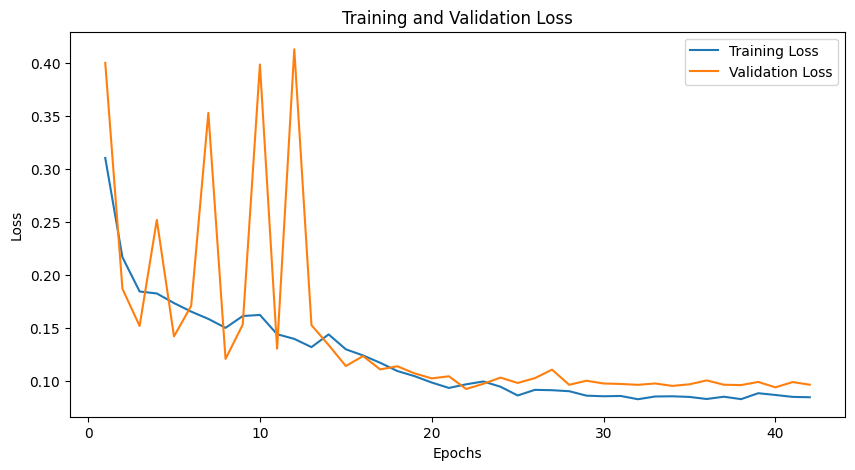

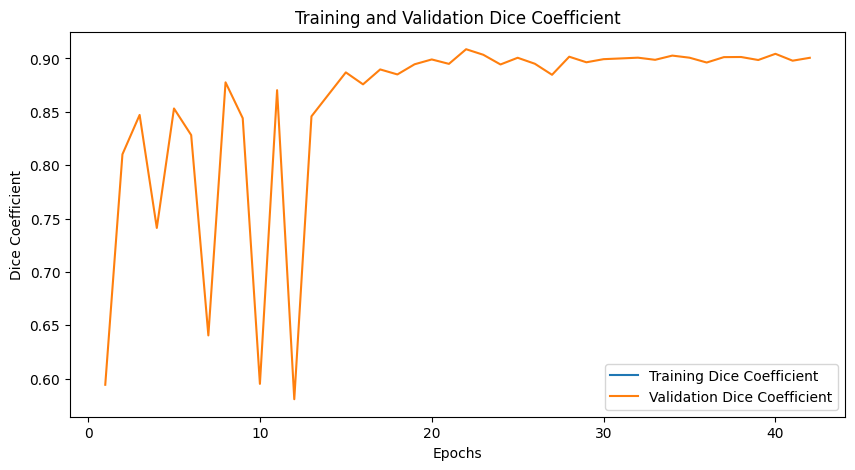

In [181]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plotting training and validation Dice coefficient
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_dice_scores) + 1), [x.item() for x in train_dice_scores], label='Training Dice Coefficient')
plt.plot(range(1, len(val_dice_scores) + 1), [x.item() for x in val_dice_scores], label='Validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.title('Training and Validation Dice Coefficient')
plt.legend()
plt.show()


In [185]:
# Function to load the model checkpoint
def load_checkpoint(checkpoint_path, model, optimizer=None):
    if os.path.isfile(checkpoint_path):
        print(f"Loading checkpoint '{checkpoint_path}'")
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        if optimizer:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_dice = checkpoint['dice']
        print(f"Loaded checkpoint '{checkpoint_path}' (epoch {start_epoch})")
        return model, optimizer, start_epoch, best_dice
    else:
        print(f"No checkpoint found at '{checkpoint_path}'")
        return model, optimizer, None, None

# Test function to evaluate the model
def test_model(model, test_loader, criterion):
    model.eval()
    test_running_loss = 0.0
    dice_scores = []

    with torch.no_grad():
        for test_data in test_loader:
            images = test_data['image'].to(device)
            labels = test_data['label'].to(device)

            outputs = model(images)
            test_loss = criterion(labels, outputs)
            test_running_loss += test_loss.item() * images.size(0)

            preds = (outputs > 0.5).float()
            dice_score = dice_coef(labels, preds)
            dice_scores.append(dice_score)

    test_loss = test_running_loss / len(test_loader.dataset)
    mean_dice = sum(dice_scores) / len(dice_scores)
    print(f"Test Loss: {test_loss:.4f}, Mean Dice Coefficient: {mean_dice:.4f}")

    return test_loss, mean_dice

# Model, Loss, Optimizer Setup
model = UNET(1, 1)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Load the trained model
checkpoint_path = '/content/drive/MyDrive/Skin_Lesion_Segmentation/model.pth'
model, optimizer, start_epoch, best_dice = load_checkpoint(checkpoint_path, model, optimizer)

# Evaluate the model on the test dataset
test_loss, mean_dice = test_model(model, test_loader, dice_loss)

Loading checkpoint '/content/drive/MyDrive/Skin_Lesion_Segmentation/model.pth'
Loaded checkpoint '/content/drive/MyDrive/Skin_Lesion_Segmentation/model.pth' (epoch 46)
Test Loss: 0.0900, Mean Dice Coefficient: 0.9115


Image shape: torch.Size([128, 128])
Mask shape: torch.Size([128, 128])
Prediction shape: torch.Size([128, 128])


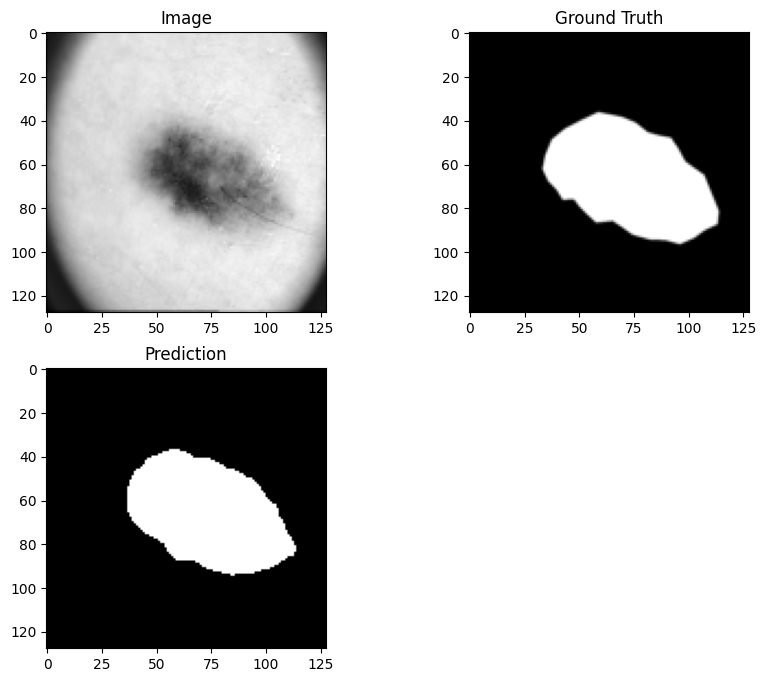

In [171]:
import torch
import matplotlib.pyplot as plt


image_test = train_dataset[14]['image']
mask_test = train_dataset[14]['label']


model.eval()


with torch.no_grad():
    y_pred = model(image_test.to(device).unsqueeze(0))
    y_pred = y_pred.squeeze(0)
    y_pred = (y_pred > 0.5).float()  # Apply threshold


image_test = image_test.squeeze()
mask_test = mask_test.squeeze()
y_pred = y_pred.squeeze().cpu()  # Move prediction to CPU for plotting

# Print shapes for debugging
print(f'Image shape: {image_test.shape}')
print(f'Mask shape: {mask_test.shape}')
print(f'Prediction shape: {y_pred.shape}')

# Plot the images
plt.figure(figsize=(10, 8))

plt.subplot(221)
plt.imshow(image_test, cmap='gray')
plt.title('Image')

plt.subplot(222)
plt.imshow(mask_test, cmap='gray')
plt.title('Ground Truth')

plt.subplot(223)
plt.imshow(y_pred, cmap='gray')
plt.title('Prediction')

plt.show()
